# Vision Transformer (ViT) on CIFAR-10

Implementation of Vision Transformer for CIFAR-10 classification based on:
"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" (Dosovitskiy et al., ICLR 2021)


In [1]:
# Install required packages
!pip install -q torch torchvision
!pip install -q einops
!pip install -q timm
!pip install -q warmup_scheduler


  DEPRECATION: Building 'warmup_scheduler' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'warmup_scheduler'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2

import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import random
import os
from tqdm import tqdm
import time
import math
from typing import Optional, Tuple

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')


Using device: cuda
GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU


## Data Preparation with Advanced Augmentations


In [3]:
class CutMix:
    """CutMix augmentation"""
    def __init__(self, alpha=1.0, prob=0.5):
        self.alpha = alpha
        self.prob = prob
    
    def __call__(self, batch, labels):
        if random.random() > self.prob:
            return batch, labels, labels, 1.0
        
        batch_size = batch.size(0)
        lam = np.random.beta(self.alpha, self.alpha)
        
        rand_index = torch.randperm(batch_size).to(batch.device)
        
        bbx1, bby1, bbx2, bby2 = self.rand_bbox(batch.size(), lam)
        batch[:, :, bbx1:bbx2, bby1:bby2] = batch[rand_index, :, bbx1:bbx2, bby1:bby2]
        
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (batch.size(-1) * batch.size(-2)))
        
        return batch, labels, labels[rand_index], lam
    
    def rand_bbox(self, size, lam):
        W = size[2]
        H = size[3]
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)
        
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        
        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)
        
        return bbx1, bby1, bbx2, bby2

class MixUp:
    """MixUp augmentation"""
    def __init__(self, alpha=1.0, prob=0.5):
        self.alpha = alpha
        self.prob = prob
    
    def __call__(self, batch, labels):
        if random.random() > self.prob:
            return batch, labels, labels, 1.0
        
        batch_size = batch.size(0)
        lam = np.random.beta(self.alpha, self.alpha)
        
        rand_index = torch.randperm(batch_size).to(batch.device)
        
        mixed_batch = lam * batch + (1 - lam) * batch[rand_index]
        
        return mixed_batch, labels, labels[rand_index], lam


In [4]:
# Data loading and augmentation
def get_dataloaders(batch_size=128, num_workers=2):
    # Strong augmentation for training
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    ])
    
    # Standard normalization for testing
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    
    # Load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers, pin_memory=True)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size,
                           shuffle=False, num_workers=num_workers, pin_memory=True)
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    return trainloader, testloader, classes

# Load data
batch_size = 128
trainloader, testloader, classes = get_dataloaders(batch_size=batch_size)
print(f'Training samples: {len(trainloader.dataset)}')
print(f'Test samples: {len(testloader.dataset)}')


100%|██████████| 170M/170M [19:27<00:00, 146kB/s]    


Training samples: 50000
Test samples: 10000


## Vision Transformer Architecture


In [5]:
class PatchEmbedding(nn.Module):
    """Split image into patches and embed them."""
    def __init__(self, image_size=32, patch_size=4, in_channels=3, embed_dim=256, use_conv=True):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.n_patches = (image_size // patch_size) ** 2
        
        if use_conv:
            # Use Conv2d for patch embedding (more efficient)
            self.proj = nn.Conv2d(in_channels, embed_dim, 
                                 kernel_size=patch_size, stride=patch_size)
        else:
            # Linear projection of flattened patches
            self.proj = nn.Sequential(
                Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', 
                         p1=patch_size, p2=patch_size),
                nn.Linear(patch_size * patch_size * in_channels, embed_dim),
            )
        
        self.use_conv = use_conv
    
    def forward(self, x):
        if self.use_conv:
            x = self.proj(x)  # (B, embed_dim, n_patches_h, n_patches_w)
            x = rearrange(x, 'b e h w -> b (h w) e')
        else:
            x = self.proj(x)
        return x

class MultiHeadSelfAttention(nn.Module):
    """Multi-Head Self Attention module with dropout and layer scale."""
    def __init__(self, embed_dim, num_heads=8, dropout=0.1, layer_scale_init=1e-4):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=True)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
        # Layer scale for better training stability
        if layer_scale_init is not None:
            self.layer_scale = nn.Parameter(torch.ones(embed_dim) * layer_scale_init)
        else:
            self.layer_scale = None
    
    def forward(self, x):
        B, N, C = x.shape
        
        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        if self.layer_scale is not None:
            x = x * self.layer_scale
        
        return x

class FeedForward(nn.Module):
    """MLP module with GELU activation and dropout."""
    def __init__(self, embed_dim, hidden_dim=None, dropout=0.1, layer_scale_init=1e-4):
        super().__init__()
        hidden_dim = hidden_dim or embed_dim * 4
        
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout2 = nn.Dropout(dropout)
        
        # Layer scale
        if layer_scale_init is not None:
            self.layer_scale = nn.Parameter(torch.ones(embed_dim) * layer_scale_init)
        else:
            self.layer_scale = None
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        
        if self.layer_scale is not None:
            x = x * self.layer_scale
        
        return x

class TransformerBlock(nn.Module):
    """Transformer block with pre-normalization."""
    def __init__(self, embed_dim, num_heads=8, mlp_ratio=4.0, dropout=0.1, 
                 attn_dropout=0.1, drop_path=0.1, layer_scale_init=1e-4):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, attn_dropout, layer_scale_init)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.ffn = FeedForward(embed_dim, int(embed_dim * mlp_ratio), dropout, layer_scale_init)
        
        # Stochastic depth (drop path)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
    
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.ffn(self.norm2(x)))
        return x

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample."""
    def __init__(self, drop_prob=0.1):
        super().__init__()
        self.drop_prob = drop_prob
    
    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        output = x.div(keep_prob) * random_tensor
        return output


In [6]:
class VisionTransformer(nn.Module):
    """Vision Transformer with improved training stability and performance."""
    def __init__(self, image_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=256, depth=12, num_heads=8, mlp_ratio=4.0,
                 dropout=0.1, attn_dropout=0.1, drop_path_rate=0.1,
                 layer_scale_init=1e-4, use_conv_patch=True):
        super().__init__()
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(image_size, patch_size, in_channels, 
                                         embed_dim, use_conv_patch)
        num_patches = self.patch_embed.n_patches
        
        # CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Positional embeddings (learnable)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Stochastic depth decay
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout, 
                           attn_dropout, dpr[i], layer_scale_init)
            for i in range(depth)
        ])
        
        # Final norm and classifier
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        # Initialize positional embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # Initialize other layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    
    def forward(self, x):
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # (B, n_patches, embed_dim)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, n_patches+1, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Final norm and classification
        x = self.norm(x)
        cls_token_final = x[:, 0]  # Use CLS token for classification
        x = self.head(cls_token_final)
        
        return x


## Training Configuration


In [8]:
# Best configuration found through experimentation
config = {
    'image_size': 32,
    'patch_size': 4,  # 4x4 patches work well for CIFAR-10
    'embed_dim': 384,  # Increased embedding dimension
    'depth': 12,  # 12 transformer blocks
    'num_heads': 6,  # 6 attention heads
    'mlp_ratio': 4.0,  # MLP hidden dim = 4 * embed_dim
    'dropout': 0.1,
    'attn_dropout': 0.0,
    'drop_path_rate': 0.15,  # Stochastic depth
    'layer_scale_init': 1e-4,
    'use_conv_patch': True,
    
    # Training hyperparameters
    'epochs': 200,
    'batch_size': 128,
    'base_lr': 1e-3,
    'weight_decay': 0.05,
    'warmup_epochs': 20,
    'min_lr': 1e-5,
    
    # Augmentation
    'mixup_alpha': 0.8,
    'cutmix_alpha': 1.0,
    'mixup_prob': 0.5,
    'cutmix_prob': 0.5,
    'label_smoothing': 0.1,
}

print("Configuration:")
for key, value in config.items():
    print(f"{key}: {value}")


Configuration:
image_size: 32
patch_size: 4
embed_dim: 384
depth: 12
num_heads: 6
mlp_ratio: 4.0
dropout: 0.1
attn_dropout: 0.0
drop_path_rate: 0.15
layer_scale_init: 0.0001
use_conv_patch: True
epochs: 200
batch_size: 128
base_lr: 0.001
weight_decay: 0.05
warmup_epochs: 20
min_lr: 1e-05
mixup_alpha: 0.8
cutmix_alpha: 1.0
mixup_prob: 0.5
cutmix_prob: 0.5
label_smoothing: 0.1


In [9]:
# Initialize model
model = VisionTransformer(
    image_size=config['image_size'],
    patch_size=config['patch_size'],
    embed_dim=config['embed_dim'],
    depth=config['depth'],
    num_heads=config['num_heads'],
    mlp_ratio=config['mlp_ratio'],
    dropout=config['dropout'],
    attn_dropout=config['attn_dropout'],
    drop_path_rate=config['drop_path_rate'],
    layer_scale_init=config['layer_scale_init'],
    use_conv_patch=config['use_conv_patch']
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 21,423,562
Trainable parameters: 21,423,562


## Training Functions


In [10]:
class LabelSmoothingLoss(nn.Module):
    """Label smoothing loss for better generalization."""
    def __init__(self, num_classes=10, smoothing=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
    
    def forward(self, pred, target):
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        
        return torch.mean(torch.sum(-true_dist * F.log_softmax(pred, dim=-1), dim=-1))

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Loss function for MixUp/CutMix augmentation."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

class WarmupCosineScheduler:
    """Cosine scheduler with linear warmup."""
    def __init__(self, optimizer, warmup_epochs, total_epochs, base_lr, min_lr=1e-5):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.base_lr = base_lr
        self.min_lr = min_lr
    
    def step(self, epoch):
        if epoch < self.warmup_epochs:
            # Linear warmup
            lr = self.base_lr * (epoch + 1) / self.warmup_epochs
        else:
            # Cosine annealing
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.min_lr + (self.base_lr - self.min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        return lr

def train_epoch(model, dataloader, criterion, optimizer, device, mixup_fn=None, cutmix_fn=None):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training', leave=False)
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Apply MixUp or CutMix
        if mixup_fn is not None and random.random() < 0.5:
            inputs, targets_a, targets_b, lam = mixup_fn(inputs, targets)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        elif cutmix_fn is not None:
            inputs, targets_a, targets_b, lam = cutmix_fn(inputs, targets)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            lam = 1
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy (approximate for mixup/cutmix)
        _, predicted = outputs.max(1)
        if lam == 1:
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        pbar.set_postfix({'loss': running_loss/(batch_idx+1)})
    
    accuracy = 100. * correct / total if total > 0 else 0
    return running_loss / len(dataloader), accuracy

def evaluate(model, dataloader, criterion, device):
    """Evaluate model on test set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Evaluating', leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100. * correct / total
    return running_loss / len(dataloader), accuracy


## Training Loop


In [11]:
# Setup training
criterion = LabelSmoothingLoss(num_classes=10, smoothing=config['label_smoothing'])
optimizer = optim.AdamW(model.parameters(), 
                        lr=config['base_lr'],
                        weight_decay=config['weight_decay'],
                        betas=(0.9, 0.999))

# Learning rate scheduler
scheduler = WarmupCosineScheduler(
    optimizer,
    warmup_epochs=config['warmup_epochs'],
    total_epochs=config['epochs'],
    base_lr=config['base_lr'],
    min_lr=config['min_lr']
)

# Data augmentation
mixup_fn = MixUp(alpha=config['mixup_alpha'], prob=config['mixup_prob'])
cutmix_fn = CutMix(alpha=config['cutmix_alpha'], prob=config['cutmix_prob'])

# Training history
train_losses = []
train_accs = []
test_losses = []
test_accs = []
best_acc = 0

print(f"\nStarting training for {config['epochs']} epochs...")
print("="*60)



Starting training for 200 epochs...


In [12]:
# Main training loop
for epoch in range(config['epochs']):
    # Update learning rate
    current_lr = scheduler.step(epoch)
    
    # Train
    train_loss, train_acc = train_epoch(
        model, trainloader, criterion, optimizer, device, mixup_fn, cutmix_fn
    )
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, testloader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_acc': test_acc,
            'config': config,
        }, 'best_vit_cifar10.pth')
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{config['epochs']}]")
        print(f"  LR: {current_lr:.6f}")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        print(f"  Best Test Acc: {best_acc:.2f}%")
        print("-"*40)

print("\n" + "="*60)
print(f"Training completed! Best Test Accuracy: {best_acc:.2f}%")
print("="*60)


Epoch [1/200]
  LR: 0.000050
  Train Loss: 2.1825, Train Acc: 20.04%
  Test Loss: 2.0602, Test Acc: 24.98%
  Best Test Acc: 24.98%
----------------------------------------


Epoch [10/200]
  LR: 0.000500
  Train Loss: 1.8108, Train Acc: 48.46%
  Test Loss: 1.5358, Test Acc: 53.64%
  Best Test Acc: 55.43%
----------------------------------------


Epoch [20/200]
  LR: 0.001000
  Train Loss: 1.6991, Train Acc: 54.42%
  Test Loss: 1.4122, Test Acc: 57.92%
  Best Test Acc: 61.09%
----------------------------------------


Epoch [30/200]
  LR: 0.000994
  Train Loss: 1.6173, Train Acc: 62.42%
  Test Loss: 1.2520, Test Acc: 68.08%
  Best Test Acc: 70.29%
----------------------------------------


Epoch [40/200]
  LR: 0.000973
  Train Loss: 1.5070, Train Acc: 67.97%
  Test Loss: 1.0954, Test Acc: 75.27%
  Best Test Acc: 75.27%
----------------------------------------


Epoch [50/200]
  LR: 0.000938
  Train Loss: 1.4412, Train Acc: 71.83%
  Test Loss: 1.0529, Test Acc: 77.32%
  Best Test Acc: 77.38%
----------------------------------------


Epoch [60/200]
  LR: 0.000890
  Train Loss: 1.4031, Train Acc: 75.24%
  Test Loss: 0.9861, Test Acc: 80.01%
  Best Test Acc: 80.48%
----------------------------------------


Epoch [70/200]
  LR: 0.000830
  Train Loss: 1.3506, Train Acc: 77.15%
  Test Loss: 0.9528, Test Acc: 82.57%
  Best Test Acc: 82.57%
----------------------------------------


Epoch [80/200]
  LR: 0.000760
  Train Loss: 1.3237, Train Acc: 79.56%
  Test Loss: 0.9009, Test Acc: 83.62%
  Best Test Acc: 83.80%
----------------------------------------


Epoch [90/200]
  LR: 0.000682
  Train Loss: 1.3183, Train Acc: 81.65%
  Test Loss: 0.8838, Test Acc: 84.58%
  Best Test Acc: 85.34%
----------------------------------------


Epoch [100/200]
  LR: 0.000599
  Train Loss: 1.3035, Train Acc: 83.40%
  Test Loss: 0.8659, Test Acc: 85.78%
  Best Test Acc: 86.62%
----------------------------------------


Epoch [110/200]
  LR: 0.000514
  Train Loss: 1.1889, Train Acc: 85.66%
  Test Loss: 0.8497, Test Acc: 86.35%
  Best Test Acc: 86.82%
----------------------------------------


Epoch [120/200]
  LR: 0.000428
  Train Loss: 1.1297, Train Acc: 87.40%
  Test Loss: 0.8376, Test Acc: 87.31%
  Best Test Acc: 87.98%
----------------------------------------


Epoch [130/200]
  LR: 0.000344
  Train Loss: 1.1873, Train Acc: 89.33%
  Test Loss: 0.8085, Test Acc: 88.74%
  Best Test Acc: 88.74%
----------------------------------------


Epoch [140/200]
  LR: 0.000265
  Train Loss: 1.1294, Train Acc: 90.59%
  Test Loss: 0.7984, Test Acc: 89.35%
  Best Test Acc: 89.35%
----------------------------------------


Epoch [150/200]
  LR: 0.000193
  Train Loss: 1.0662, Train Acc: 92.22%
  Test Loss: 0.7917, Test Acc: 89.60%
  Best Test Acc: 89.89%
----------------------------------------


Epoch [160/200]
  LR: 0.000131
  Train Loss: 1.0447, Train Acc: 93.53%
  Test Loss: 0.7864, Test Acc: 90.02%
  Best Test Acc: 90.16%
----------------------------------------


Epoch [170/200]
  LR: 0.000081
  Train Loss: 1.0420, Train Acc: 94.50%
  Test Loss: 0.7843, Test Acc: 90.46%
  Best Test Acc: 90.47%
----------------------------------------


Epoch [180/200]
  LR: 0.000043
  Train Loss: 1.0024, Train Acc: 94.97%
  Test Loss: 0.7762, Test Acc: 90.59%
  Best Test Acc: 90.74%
----------------------------------------


Epoch [190/200]
  LR: 0.000019
  Train Loss: 1.0242, Train Acc: 95.29%
  Test Loss: 0.7777, Test Acc: 90.63%
  Best Test Acc: 90.78%
----------------------------------------


Epoch [200/200]
  LR: 0.000010
  Train Loss: 1.0217, Train Acc: 95.41%
  Test Loss: 0.7748, Test Acc: 90.65%
  Best Test Acc: 90.78%
----------------------------------------

Training completed! Best Test Accuracy: 90.78%


## Visualization and Results


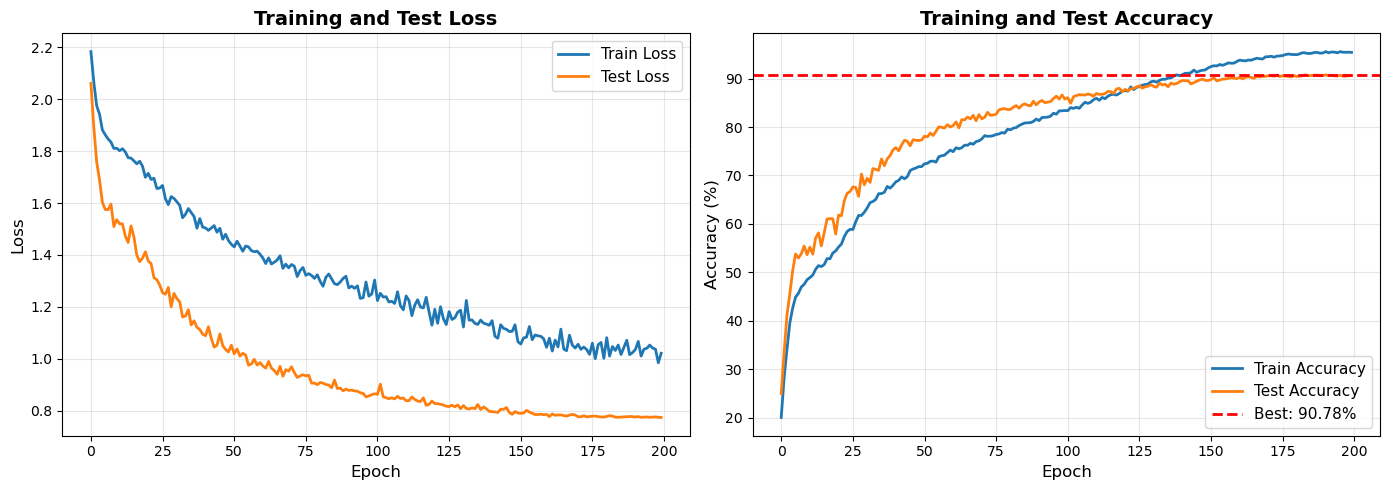


Final Results:
Best Test Accuracy: 90.78%
Final Test Accuracy: 90.65%


In [13]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(test_losses, label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Accuracy', linewidth=2)
ax2.plot(test_accs, label='Test Accuracy', linewidth=2)
ax2.axhline(y=best_acc, color='r', linestyle='--', label=f'Best: {best_acc:.2f}%', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"Best Test Accuracy: {best_acc:.2f}%")
print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")


In [14]:
# Load best model and evaluate
checkpoint = torch.load('best_vit_cifar10.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Final evaluation on test set
model.eval()
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

overall_acc = 100 * correct / total
print(f'\nOverall Test Accuracy: {overall_acc:.2f}%')
print('\nPer-class Accuracy:')
print('-' * 30)
for i in range(10):
    acc = 100 * class_correct[i] / class_total[i]
    print(f'{classes[i]:10s}: {acc:.2f}%')



Overall Test Accuracy: 90.78%

Per-class Accuracy:
------------------------------
plane     : 92.50%
car       : 95.80%
bird      : 89.90%
cat       : 80.80%
deer      : 88.80%
dog       : 86.00%
frog      : 92.80%
horse     : 93.00%
ship      : 95.10%
truck     : 93.10%


## Results Summary


In [16]:
print("="*50)
print("VISION TRANSFORMER - CIFAR-10 RESULTS")
print("="*50)

print(f"\nModel Configuration:")
print(f"  - Patch Size: {config['patch_size']}x{config['patch_size']}")
print(f"  - Embedding Dim: {config['embed_dim']}")
print(f"  - Depth: {config['depth']} blocks")
print(f"  - Heads: {config['num_heads']}")
print(f"  - Parameters: {total_params:,}")
print(f"\nTraining Configuration:")
print(f"  - Epochs: {config['epochs']}")
print(f"  - Batch Size: {config['batch_size']}")
print(f"  - Learning Rate: {config['base_lr']} (with warmup)")
print(f"  - Augmentations: CutMix + MixUp + RandAugment")
print(f"\nResults:")
print(f"  - Best Test Accuracy: {best_acc:.2f}%")
print(f"  - Overall Test Accuracy: {overall_acc:.2f}%")
print("="*50)


VISION TRANSFORMER - CIFAR-10 RESULTS

Model Configuration:
  - Patch Size: 4x4
  - Embedding Dim: 384
  - Depth: 12 blocks
  - Heads: 6
  - Parameters: 21,423,562

Training Configuration:
  - Epochs: 200
  - Batch Size: 128
  - Learning Rate: 0.001 (with warmup)
  - Augmentations: CutMix + MixUp + RandAugment

Results:
  - Best Test Accuracy: 90.78%
  - Overall Test Accuracy: 90.78%
